<a href="https://colab.research.google.com/github/rrizwan98/Amazon_Reviews/blob/main/Climate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/derive')

Mounted at /content/derive


In [ ]:
# jena_climate data to unzip form

from zipfile import ZipFile
file_name='/content/derive/My Drive/jena_climate.zip'
with ZipFile(file_name , 'r') as zip:
  zip.extractall()
  print('raza')


raza


In [ ]:
# import important libraries

import numpy as np
import pandas as pd
import os

In [ ]:
#create directory to and apth join

data_dir = '../input/'
fname = os.path.join(data_dir,'/content/jena_climate_2009_2016.csv')
print(fname)

/content/jena_climate_2009_2016.csv


In [ ]:
f=open(fname)
data=f.read()
f.close

lines=data.split('\n')
header=lines[0].split(',')
lines=lines[1:]

print(header)
print(len(lines))
print(lines[0])

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551
01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.30


In [ ]:
float_data=np.zeros((len(lines) , len(header) -1))
for i , line in enumerate(lines):
  value=[float(x) for x in line.split(',')[1:]] 
  float_data[1 , :] = value

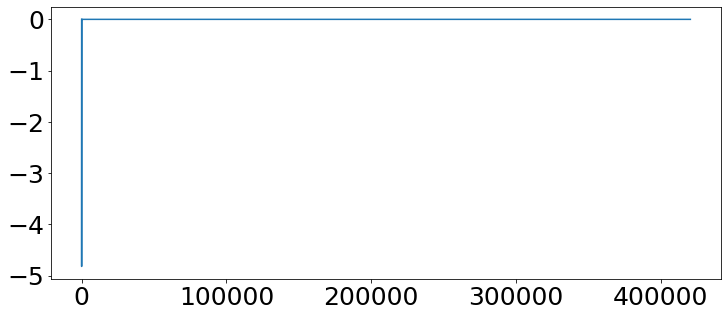

In [ ]:
import matplotlib.pyplot as plt

temp=float_data[:,1]
plt.figure(figsize=(12,5))
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.plot(range(len(temp)),temp)


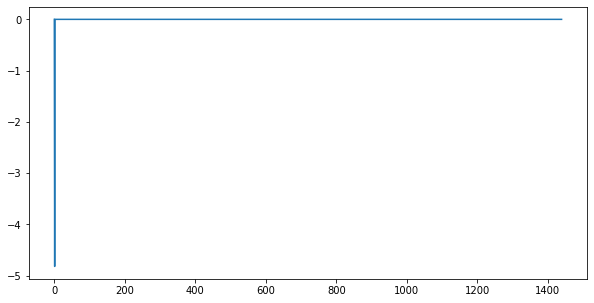

In [ ]:
plt.figure(figsize=(10,5))
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.plot(range(1440) , temp[:1440])
plt.show()

In [ ]:
mean=float_data[:200000].mean (axis=0)
float_data -=mean
std=float_data[:200000].std(axis=0)
float_data /=std
std

array([2.23565990e+00, 1.07778207e-02, 6.00069702e-01, 1.88276453e-02,
       1.69269923e-01, 9.54798639e-03, 7.22248151e-03, 2.32550488e-03,
       4.49448540e-03, 7.22248151e-03, 2.89878656e+00, 2.75035674e-03,
       4.38268228e-03, 4.13447935e-01])

In [ ]:
def generator(data, lookback, delay, min_index, max_index,shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    
    i = min_index + lookback
    while True:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size = batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),lookback//step,data.shape[1]))
            
        targets = np.zeros((len(rows),))
        #print('Rows:',rows[:3])
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets


In [ ]:
lookback=1440
step=6
delay=144
batch_size=128

train_gen=generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=0,
                    max_index=200000,
                    shuffle=True,
                    step=step,
                    batch_size=batch_size)
val_gen=generator(float_data,
                  lookback=lookback,
                  delay=delay,
                  min_index=200001,
                  max_index=300000,
                  shuffle=True,
                  step=step,
                  batch_size=batch_size)
test_gen=generator(float_data,
                   lookback=lookback,
                   delay=delay,
                   min_index=300001,
                   max_index=None,
                   shuffle=True,
                   step=step,
                   batch_size=batch_size)

val_steps=(300000-200001-lookback)//batch_size
test_steps=(len(float_data)-300001)//batch_size

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten,Dense
from keras.optimizers import RMSprop

model = Sequential()
model.add(Flatten(input_shape=(lookback//step,float_data.shape[-1])))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer=RMSprop(),loss='mae', metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 3360)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                107552    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit_generator(train_gen,steps_per_epoch=500,epochs=5,validation_data=val_gen,validation_steps=val_steps)

Epoch 1/5
500/500 [==============================] - 16s 32ms/step - loss: 0.0010 - acc: 0.0000e+00 - val_loss: 9.8555e-04 - val_acc: 0.0000e+00
Epoch 2/5
500/500 [==============================] - 16s 32ms/step - loss: 8.4217e-04 - acc: 0.0000e+00 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 3/5
500/500 [==============================] - 16s 32ms/step - loss: 0.0000e+00 - acc: 0.0000e+00 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 4/5
500/500 [==============================] - 16s 32ms/step - loss: 0.0000e+00 - acc: 0.0000e+00 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 5/5
500/500 [==============================] - 16s 32ms/step - loss: 4.6035e-04 - acc: 0.0000e+00 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00


<Figure size 432x288 with 0 Axes>

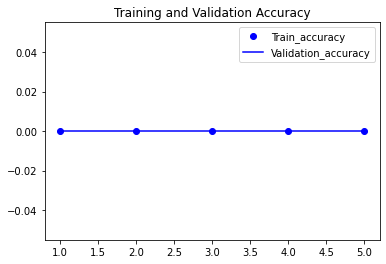

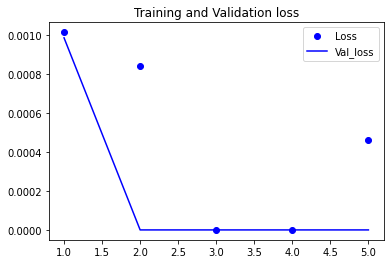

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1,len(acc)+1)

plt.plot(epochs , acc , 'bo' , label='Train_accuracy')
plt.plot(epochs , val_acc , 'b' ,label='Validation_accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs , loss , 'bo' ,label='Loss')
plt.plot(epochs , val_loss , 'b', label='Val_loss')
plt.title('Training and Validation loss')
plt.legend()

plt.figure()

In [ ]:
model.evaluate(train_gen, batch_size=128 , verbose=2)

In [ ]:
from keras.layers import GRU

model_2=SEquential()
model_2.add(GRU(32,input_shape=(None , float_data.shape[-1])))
model_2.add(Dense(1))
model_2.compile(optimizer=RMSprop() , loss='mae')
model_2.fit(train_gen , steps_per_epochs=500 , epochs=10 , validation_data=val_gen , validation_data=val_steps)